<a href="https://colab.research.google.com/github/Murcha1990/ML_AI24/blob/main/Hometasks/Base/AI_HW4_woodenML_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Домашнее задание 4 (base): древесные алгоритмы**

### **Постановка задачи:**

У вас есть данные о полетах, обладающие следущими характеристиками:
- Для **каждого** клиента известна краткая информация о самом человеке, о типе билета и о рейсе, а также оценки клиента различным аспектам полета.
- Для **некоторых** клиентов известна их удовлетворенность полетом (satisfied или neutral or dissatisfied).

По данным необходимо обучить модель, предсказывающую удовлетворенность клиентов полетом. Итоговые предсказания нужно сделать для клиентов, **для которых ответ неизвестен.**

### **Получение данных:**

Компания держит все данные в облаке Яндекса в Postgresql. Данные разбиты на смысловые таблицы. Чтобы получить данные, вам необходимо подключиться к базе данных и добыть оттуда данные.

### **Оценивание:**

- Как всегда оцениваются как код, так и ответы на вопросы. Если нет одного и/или другого, то часть баллов за соответствующее задание без колебаний снимается.
- Брать код из открытых источников позволительно. Следование культуре цитирования **обязательно.**

### **Баллы:**

Суммарно за задание можно получить 10 основных и 0.7 бонусных баллов.

Оценка за ДЗ = min{ваш балл, 10}

Мягкий дедлайн: 25 января 23:59

**Продуктивной и интересной вам работы!**

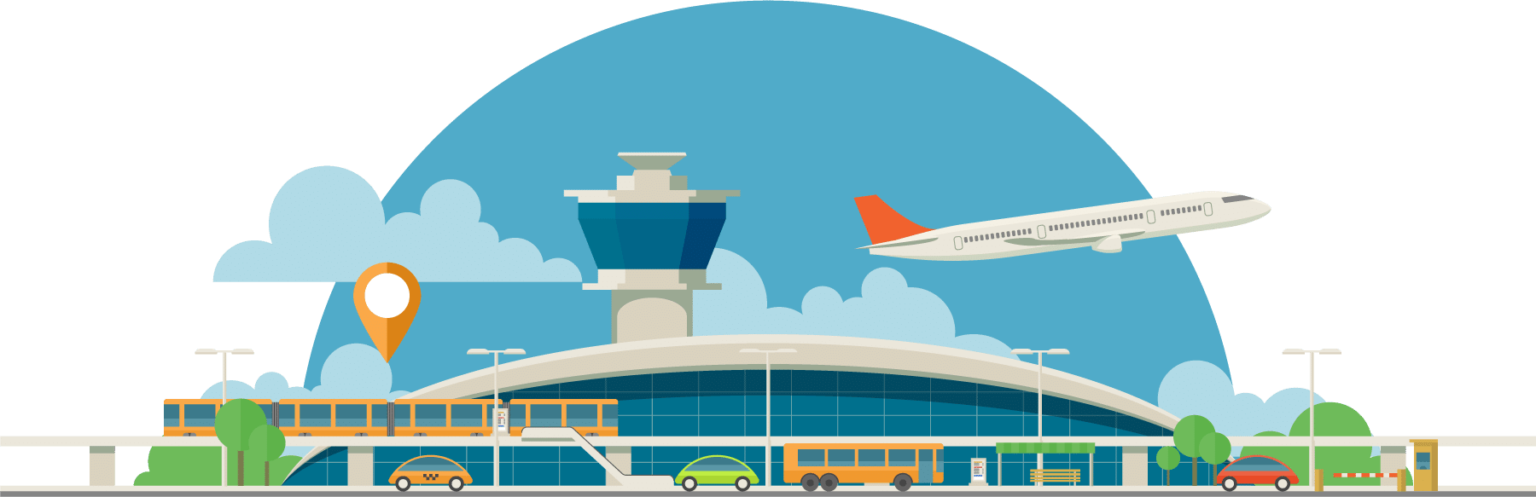

In [ ]:
# установка всех библиотек, необходимых для выполнения ДЗ

!pip install catboost
!pip install mlxtend --upgrade
!pip install optuna
!pip install lime
!pip install shap
!pip install missingno
!pip install psycopg2-binary
#!pip install xgboost
#!brew install cmake libomp
#!pip install lightgbm

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import missingno

import psycopg2
import psycopg2.extras

from mlxtend.plotting import plot_decision_regions
from mlxtend.evaluate import bias_variance_decomp
from graphviz import Source
from sklearn.tree import export_graphviz
from IPython.display import SVG

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.calibration import CalibrationDisplay
from sklearn.isotonic import IsotonicRegression

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from catboost import CatBoostClassifier
# from xgboost import XGBClassifier
# from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, mutual_info_classif
from sklearn.feature_selection import SequentialFeatureSelector, RFE, SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator

import shap
import lime
import lime.lime_tabular

import optuna

import pickle

np.random.seed(42)

# **Часть 1: Получение данных, обработка и EDA (2.75 балла)**

В этой части вам необходимо:
- Загрузить данные из БД и предобработать их (1.75 бала)
- Провести разведочный анализ данных (1. балл)

## **1. 1. Загрузка и предобработка данных (1.75 балла)**

In [ ]:
!mkdir -p ~/.postgresql && \
wget "https://storage.yandexcloud.net/cloud-certs/CA.pem" \
    --output-document ~/.postgresql/root.crt && \
chmod 0600 ~/.postgresql/root.crt

### **Задание 1. Получение данных (0.5 балла)**

- Подключитесь к БД при помощи `psycopg2.connect()`
- Напишите SQL-запрос, объединяющий 3 нужные таблицы в одну
- Результат запроса поместите в `pd.DataFrame`. Индексом получившегося датафрейма сделайте столбец 'id'.

Список столбцов таблиц добудьте самостоятельно.


**Примечание:**
 Не забудьте закрыть соединение. Или открывайте соединение, используя менеджер контекста `with as`, который закроет его автоматически

##### **Параметры соединения:**
```
host=rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net
port=6432
sslmode=verify-full
dbname=db_flights
user=mlhs_student
password=mlhs_student
target_session_attrs=read-write```
```

##### **Схема БД**

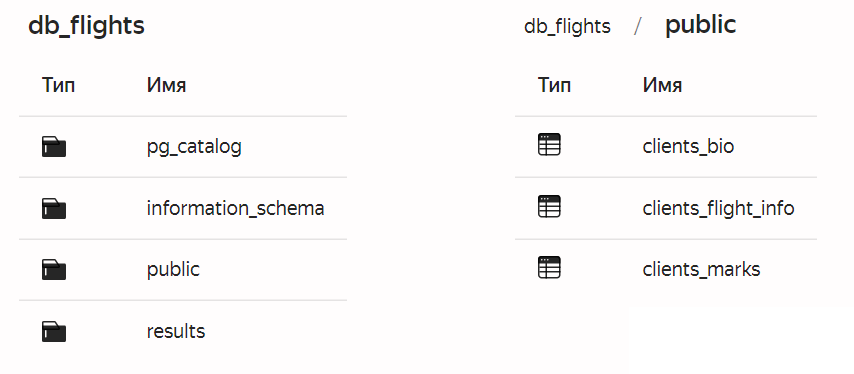



In [2]:
dsn = 'dbname=db_flights user=mlhs_student password=mlhs_student host=rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net port=6432'

In [3]:
with psycopg2.connect(dsn=dsn) as conn:
    with conn.cursor() as cur:
        for table in ['clients_bio', 'clients_flight_info', 'clients_marks']:    
            cur.execute(f'''
            SELECT column_name
            FROM information_schema.columns
            WHERE table_schema = 'public' AND table_name = '{table}'
            ''')
            print(f'{table} columns: {cur.fetchall()}')

clients_bio columns: [('id',), ('gender',), ('age',)]
clients_flight_info columns: [('id',), ('Customer Type',), ('Type of Travel',), ('class',), ('Flight Distance',), ('Departure Delay in Minutes',), ('Arrival Delay in Minutes',)]
clients_marks columns: [('id',), ('Inflight wifi service',), ('Departure/Arrival time convenient',), ('Ease of Online booking',), ('Gate location',), ('Food and drink',), ('Online boarding',), ('Seat comfort',), ('Inflight entertainment',), ('On-board service',), ('Leg room service',), ('Baggage handling',), ('Checkin service',), ('Inflight service',), ('cleanliness',), ('satisfaction',)]


`У таблиц из схемы public первичным ключом являются столбцы id.`

In [4]:
with psycopg2.connect(dsn=dsn) as conn:
    with conn.cursor() as cur:
        cur.execute('''
        SELECT *
        FROM clients_bio JOIN clients_flight_info 
        USING(id)
        JOIN clients_marks
        USING(id)
        ''')
        columns = [x[0] for x in cur.description]
        data = cur.fetchall()
        df = pd.DataFrame(data, columns=columns)

df.set_index('id', inplace=True)

In [5]:
assert df.shape == (129_549, 23)

### **Задание 2 (0.25 балла)**

- Преобразуйте числовые столбцы в `float`. Проверьте, есть ли в датафрейме пропуски и выбросы (в том числе в категориальных признаках)</font>.

In [6]:
def to_float(df):
    """
    Преобразование числовых столбцов во float.
    """
    df_copy = df.copy()
    for column in df_copy.columns:
        try:
            df_copy[column] = df_copy[column].astype(float)
        except ValueError:
            continue
    return df_copy

df = to_float(df)

In [7]:
df.isna().sum()

gender                                 0
age                                  315
Customer Type                          0
Type of Travel                         0
class                                  0
Flight Distance                       94
Departure Delay in Minutes           107
Arrival Delay in Minutes             507
Inflight wifi service                 44
Departure/Arrival time convenient     49
Ease of Online booking                43
Gate location                         37
Food and drink                        50
Online boarding                       46
Seat comfort                          47
Inflight entertainment                45
On-board service                      44
Leg room service                      46
Baggage handling                      48
Checkin service                       42
Inflight service                      63
cleanliness                           37
satisfaction                           0
dtype: int64

In [8]:
df.describe()

,age,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,cleanliness
count,129234.000000,129455.000000,129442.000000,129042.000000,129505.000000,129500.000000,129506.000000,129512.000000,129499.000000,129503.000000,129502.000000,129504.000000,129505.000000,129503.000000,129501.000000,129507.000000,129486.000000,129512.000000
mean,40.116951,1322.922158,15.809026,16.656499,2.732327,3.062131,2.760722,2.981708,3.208141,3.256782,3.445669,3.361232,3.387259,3.355976,3.635872,3.309976,3.646927,3.289780
std,20.376129,4517.816532,93.276882,109.285072,1.360033,1.559627,1.431048,1.312873,1.357546,1.381888,1.349713,1.366908,1.335697,1.361670,1.222039,1.298827,1.218748,1.347466
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,414.000000,0.000000,0.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000
50%,40.000000,846.000000,0.000000,0.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000
75%,51.000000,1744.000000,12.000000,13.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000
max,621.000000,379620.000000,22227.000000,14006.000000,45.000000,45.000000,45.000000,36.000000,45.000000,40.000000,45.000000,45.000000,45.000000,40.000000,40.000000,45.000000,40.000000,45.000000


`Судя по разнице между медианами и максимольными значениями, выбросы есть во всех численных столбцах.`

In [9]:
df.describe(include='object')

,gender,Customer Type,Type of Travel,class,satisfaction
count,129549,129549,129549,129549,129549
unique,2,3,3,4,3
top,Female,Loyal Customer,Business travel,Business,neutral or dissatisfied
freq,65726,105763,89405,61939,58732


In [10]:
def print_value_counts(df):
    """
    Вывод уникальных значений и их долей для всех категориальных признаков.
    """
    for column in df.select_dtypes(include='object').columns:
        print(df[column].value_counts(normalize=True))
        print('-----------------------------------')

print_value_counts(df)

gender
Female    0.507345
Male      0.492655
Name: proportion, dtype: float64
-----------------------------------
Customer Type
Loyal Customer       0.816394
disloyal Customer    0.183012
nan                  0.000594
Name: proportion, dtype: float64
-----------------------------------
Type of Travel
Business travel    0.690125
Personal Travel    0.309095
nan                0.000780
Name: proportion, dtype: float64
-----------------------------------
class
Business    0.478113
Eco         0.448595
Eco Plus    0.072397
nan         0.000895
Name: proportion, dtype: float64
-----------------------------------
satisfaction
neutral or dissatisfied    0.453357
satisfied                  0.346680
-                          0.199963
Name: proportion, dtype: float64
-----------------------------------


`В категориальных признаках есть выбросы, принимающие значения отдельной категории nan.`

### **Задание 3 (0.5 балла)**

Воспользуйтесь модулем `missingno` для визуализации пропусков в датафрейме. Постройте:
-  `matrix` пропущенных значений;
- столбчатую диаграмму в **логарифмированной** шкале (так как пропусков немного, по обычной не будет видно, в каких столбцах их больше)

<Axes: >

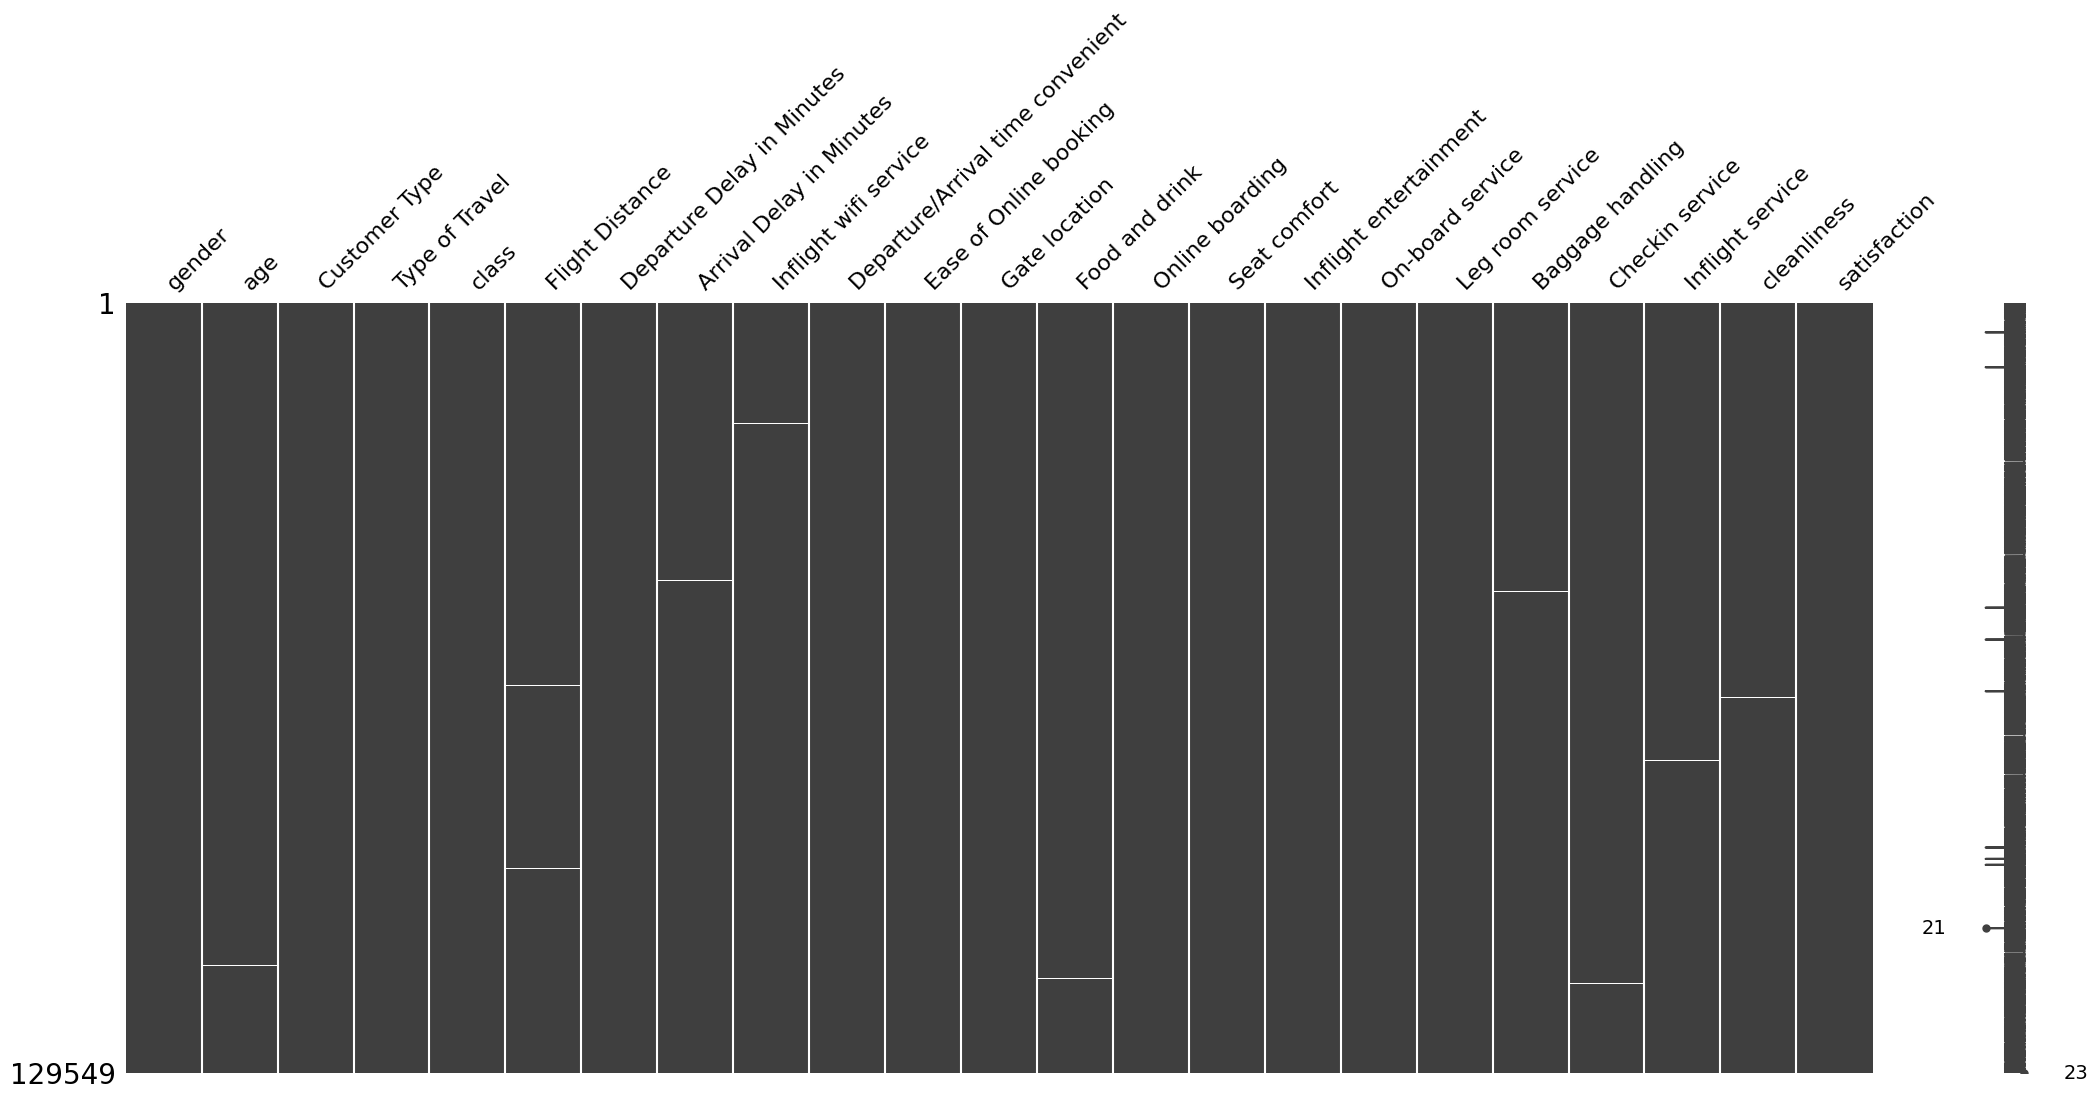

In [11]:
missingno.matrix(df)

/home/vasily/ml-hse-24-25/.venv/lib/python3.10/site-packages/missingno/missingno.py:271: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(n * len(df)) for n in ax1.get_yticks()], fontsize=fontsize)


<Axes: >

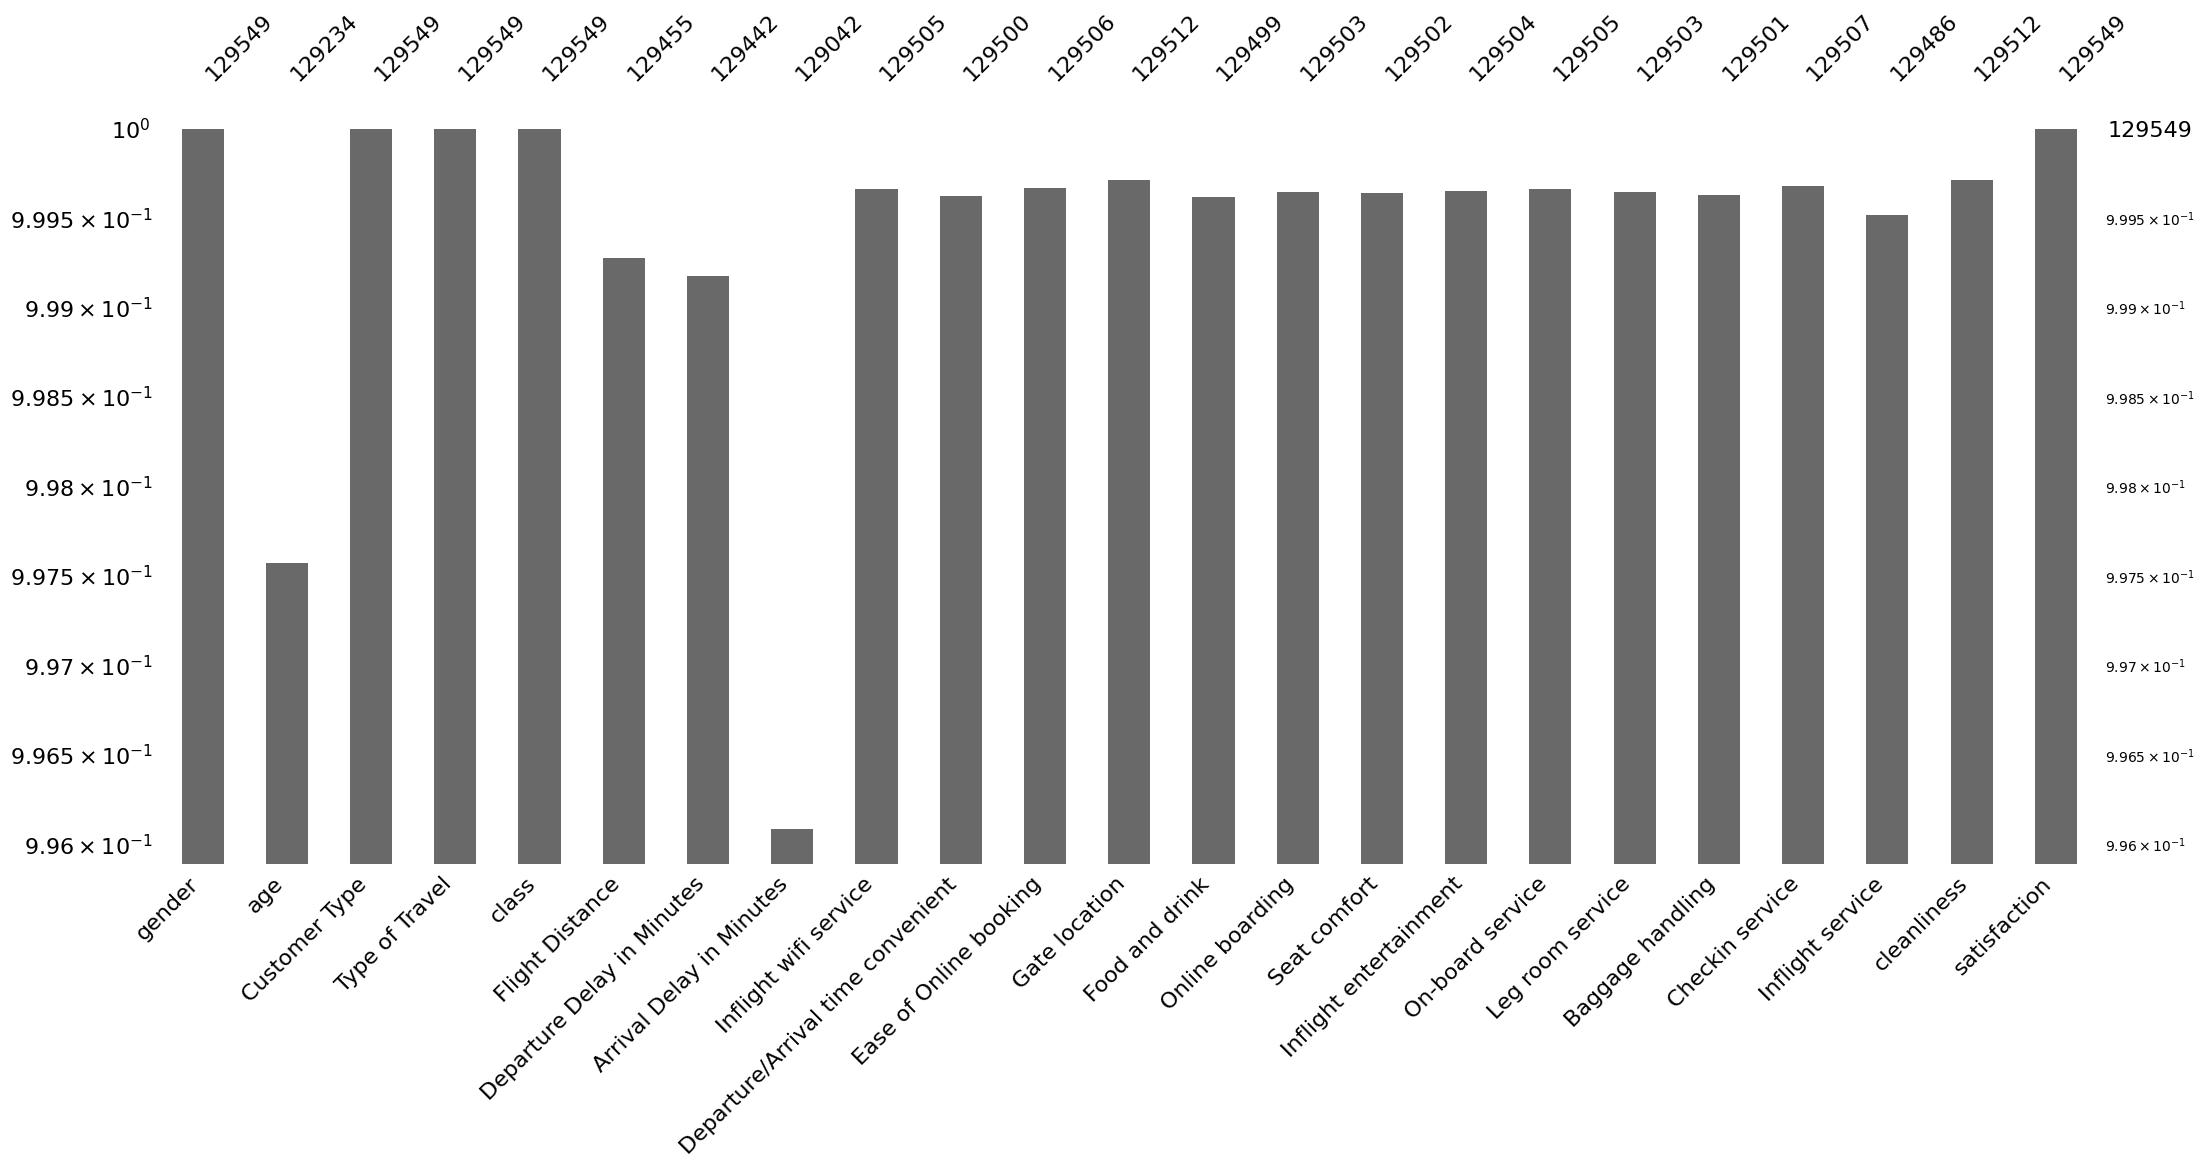

In [12]:
missingno.bar(df, log=True)

Разобьем датасет на тренировочную и тестовую части. Тестовую часть отложим надолго -- до самого конца этого ноутбука.

In [13]:
df_train = df[df.satisfaction != '-']
df_train

,gender,age,Customer Type,Type of Travel,class,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes,Inflight wifi service,Departure/Arrival time convenient,...,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,cleanliness,satisfaction
id,,,,,,,,,,,,,,,,,,,,,
7,Male,43.0,Loyal Customer,Business travel,Business,1963.0,0.0,0.0,3.0,3.0,...,4.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,4.0,satisfied
13,Male,24.0,disloyal Customer,Business travel,Eco,453.0,16.0,30.0,2.0,2.0,...,2.0,5.0,5.0,2.0,4.0,4.0,2.0,4.0,5.0,neutral or dissatisfied
18,Female,61.0,Loyal Customer,Personal Travel,Eco,821.0,0.0,0.0,2.0,5.0,...,1.0,5.0,5.0,5.0,2.0,5.0,5.0,5.0,1.0,neutral or dissatisfied
31,Male,35.0,disloyal Customer,Business travel,Business,212.0,0.0,0.0,2.0,2.0,...,2.0,2.0,2.0,4.0,5.0,5.0,5.0,4.0,2.0,neutral or dissatisfied
39,Female,46.0,Loyal Customer,Business travel,Business,67.0,0.0,0.0,3.0,3.0,...,5.0,4.0,4.0,4.0,4.0,4.0,5.0,4.0,5.0,satisfied
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129831,Female,28.0,Loyal Customer,Personal Travel,Eco,447.0,23.0,16.0,1.0,3.0,...,1.0,3.0,3.0,1.0,1.0,4.0,1.0,5.0,3.0,neutral or dissatisfied
129837,Male,66.0,Loyal Customer,Personal Travel,Eco,337.0,199.0,213.0,2.0,4.0,...,5.0,5.0,5.0,2.0,4.0,5.0,5.0,4.0,5.0,neutral or dissatisfied
129838,Female,59.0,Loyal Customer,Personal Travel,Eco,308.0,32.0,24.0,3.0,5.0,...,5.0,5.0,3.0,3.0,3.0,3.0,4.0,3.0,4.0,neutral or dissatisfied


In [14]:
assert df_train.shape == (103_644, 23)

In [15]:
df_test = df[df.satisfaction == '-'].drop('satisfaction', axis=1)
df_test

,gender,age,Customer Type,Type of Travel,class,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes,Inflight wifi service,Departure/Arrival time convenient,...,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,cleanliness
id,,,,,,,,,,,,,,,,,,,,,
55,Male,36.0,Loyal Customer,Business travel,Business,3655.0,40.0,71.0,1.0,1.0,...,1.0,3.0,3.0,3.0,3.0,3.0,1.0,4.0,3.0,2.0
79,Female,70.0,Loyal Customer,Personal Travel,Eco,108.0,50.0,41.0,5.0,4.0,...,4.0,4.0,4.0,3.0,3.0,0.0,3.0,5.0,3.0,5.0
126,Male,66.0,Loyal Customer,Personal Travel,Eco,562.0,88.0,84.0,2.0,5.0,...,5.0,2.0,5.0,5.0,3.0,5.0,2.0,5.0,5.0,5.0
199,Female,60.0,Loyal Customer,Business travel,Business,3756.0,36.0,24.0,4.0,4.0,...,2.0,4.0,5.0,4.0,4.0,4.0,4.0,5.0,4.0,5.0
263,Male,43.0,Loyal Customer,Personal Travel,Business,802.0,0.0,0.0,1.0,2.0,...,2.0,3.0,3.0,2.0,2.0,1.0,2.0,3.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129750,Male,38.0,Loyal Customer,Business travel,Eco,337.0,92.0,82.0,4.0,3.0,...,4.0,5.0,4.0,4.0,4.0,5.0,4.0,5.0,3.0,4.0
129771,Male,16.0,Loyal Customer,Personal Travel,Eco,308.0,2.0,0.0,3.0,4.0,...,1.0,3.0,5.0,1.0,4.0,2.0,5.0,5.0,4.0,1.0
129798,Female,43.0,Loyal Customer,Personal Travel,Eco,308.0,0.0,0.0,2.0,4.0,...,3.0,5.0,5.0,4.0,4.0,2.0,4.0,4.0,4.0,5.0


In [16]:
assert df_test.shape == (25_905, 22)

Разбиваем данные на трейн и валидацию. Не меняйте сид

In [17]:
X_train, X_val, y_train, y_val = train_test_split(df_train.drop('satisfaction', axis=1), df_train.satisfaction, test_size=0.3, random_state=42)

In [18]:
assert X_train.shape == (72_550, 22)
assert X_val.shape == (31_094, 22)

### **Задание 4. (0.15 балла)**

Заполните пропуски в данных наиболее часто встречающимся значением.
Помните про правильность заполнения.

**Примечание:** Мы также могли восстановать пропуски `KNNImputer`'ом или `IterativeImputer`'ом. Как правило, такое заполнение точнее и лучше сохраняет структуру распределений. Но для признаков в нашей задаче Imputer'ы, реализованные библиотечно не подошли бы. Они возвращали бы вещественные значения, а в нашей задаче все признаки целые.

In [19]:
from sklearn.base import BaseEstimator, TransformerMixin

class NaNSimpleImputer(BaseEstimator, TransformerMixin):
    """
    SimpleImputer, который заполняет np.nan и строковые 'nan'.
    """
    def __init__(self, strategy='most_frequent'):
        self.strategy = strategy
        self.imputer = SimpleImputer(strategy=self.strategy, missing_values=np.nan)
        
    def fit(self, X, y=None):
        X_copy = X.copy()
        X_copy = X_copy.replace('nan', np.nan)
        self.imputer.fit(X_copy)
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy = X_copy.replace('nan', np.nan)
        X_copy = self.imputer.transform(X_copy)
        data = pd.DataFrame(data=X_copy, columns=self.imputer.get_feature_names_out(), index=X.index)
        return to_float(data)

In [20]:
imputer = NaNSimpleImputer(strategy='most_frequent')

X_train = imputer.fit_transform(X_train)
X_val = imputer.transform(X_val)

### **Задание 5. (0.1 балла)**

- Выведите основные статистики по числовым и категориальным столбцам таблицы
- Сделайте **текстовый** вывод о распределениях значений признаков

In [21]:
X_train.describe()

,age,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,cleanliness
count,72550.000000,72550.000000,72550.000000,72550.000000,72550.000000,72550.000000,72550.000000,72550.000000,72550.000000,72550.000000,72550.000000,72550.000000,72550.000000,72550.000000,72550.000000,72550.000000,72550.000000,72550.000000
mean,40.098856,1329.018332,15.859366,16.645968,2.733687,3.065017,2.761006,2.982688,3.209318,3.256513,3.445665,3.362150,3.383101,3.352364,3.630255,3.309056,3.640234,3.291178
std,20.658196,4764.369357,70.861937,97.990293,1.362172,1.552254,1.414843,1.316648,1.349963,1.372739,1.346077,1.360862,1.333758,1.360180,1.227853,1.293114,1.215114,1.343302
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,413.000000,0.000000,0.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000
50%,40.000000,844.000000,0.000000,0.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000
75%,51.000000,1744.000000,12.000000,13.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000
max,544.000000,379620.000000,9282.000000,11760.000000,45.000000,45.000000,28.000000,36.000000,36.000000,32.000000,45.000000,40.000000,45.000000,36.000000,40.000000,45.000000,36.000000,45.000000


In [22]:
X_train.describe(include='object')

,gender,Customer Type,Type of Travel,class
count,72550,72550,72550,72550
unique,2,2,2,3
top,Female,Loyal Customer,Business travel,Business
freq,36816,59406,50054,34793


In [23]:
print_value_counts(X_train)

gender
Female    0.507457
Male      0.492543
Name: proportion, dtype: float64
-----------------------------------
Customer Type
Loyal Customer       0.818828
disloyal Customer    0.181172
Name: proportion, dtype: float64
-----------------------------------
Type of Travel
Business travel    0.689924
Personal Travel    0.310076
Name: proportion, dtype: float64
-----------------------------------
class
Business    0.479573
Eco         0.448601
Eco Plus    0.071826
Name: proportion, dtype: float64
-----------------------------------


`Как уже было сказано ранее, во всех численных призаках есть выбросы. При этом многие признаки обладают смещенным относительно медианы средним, что свидетельствует о весомом влияние выбросов на среднее.`

`На признаках Departure Delay in Minutes, Arrival Delay in Minutes большинство объектов принимает нулевое значение.`

`Что касается категориальных признаков: gender хорошо сбалансирован; class имеет cбалансированные две категории и одну редкую;  Type of Travel и Customer Type имееют дисбаланс категорий.`

### **Задание 6 (0.25 балла)**

- Удалите строки c выбросами в числовых столбцах (для трейна и валидации; тест оставьте без изменений).

**Примечание:** Выбросами считайте значения признака, строго превышающие 0.996-квантиль.

По определению, квантиль — значение, которое заданная случайная величина не превышает с фиксированной вероятностью. То есть, если мы смотрим на квантиль 0.996-квантиль, то значения после этого квантиля встречаются в 0.004% случаев. В среднем для всех признаков эти значения начинаются ~в этом квантиле.



In [24]:
class DropEmissions(BaseEstimator, TransformerMixin):
    """
    Удаляет объекты с выбросами в числовых столбцах.
    """
    def __init__(self):
        self.q = {}
    
    def fit(self, X, y=None):
        X_copy = X.copy()
        for column in X_copy.select_dtypes(include='number').columns:
            self.q[column] = X_copy[column].quantile(0.996)
        return self
            
    def transform(self, X):
        X_copy = X.copy()
        for column in X_copy.select_dtypes(include='number').columns:
            X_copy = X_copy[X_copy[column] <= self.q[column]]
        return X_copy

In [25]:
droper = DropEmissions()

X_train = droper.fit_transform(X_train)
y_train = y_train.loc[X_train.index]

X_val = droper.fit_transform(X_val)
y_val = y_val.loc[X_val.index]

In [26]:
assert df_test.shape == (25_905, 22)

## **1. 2. EDA (1 балл)**

Создадим переменные с перечислениями столбцов разного типа

In [27]:
continuous_cols = ['age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
ordinal_cols = list(set(df.select_dtypes(include='number').columns) - set(continuous_cols))
categorical_cols = list(df.select_dtypes(include='object').columns)[:-1]

In [156]:
assert len(continuous_cols + ordinal_cols + categorical_cols) == 22

### **Задание 7. (0.3 балла)**

- Напишите процедуры для отрисовки графиков;
 * Для признаков, которые мы выделили как порядковые и для категориальных, отображайте только `countplot`
  * Для тех, что считаем континуальными, -- гистограмму распределения признака и ящик с усами (inline)

- Вызовите все 3 написанные процедуры для соответствующих колонок `X_train`. Отдельно визуализируйте распределение таргета в трейне. Всё должно красиво работать! :)

**Примечание 1:**

Помните про хороший тон визуализации — все графики и их оси обязательно должны быть подписаны, легенда на графике также необходима! За неё также могут быть сняты баллы.

**Примечание 2:**

Обязательно выделяйте таргет разными цветами. Мы же хотим в конечном итоге понять, чем удовлетворенные клиенты отличаются от недовольных.

In [168]:
def plot_ordinal(cols, df, y):
    """Draws countplots for all columns in 'cols' with informative title"""
    k = 3 # Кол-во графиков в строке
    m = 3.5 # Масштаб
    n_rows = int(np.ceil(len(cols) / k))
    n_cols = k
    
    fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(8 * m, 12 * m))
    fig.subplots_adjust(wspace=0.3, hspace=0.3)
    
    i = 0
    for row in range(n_rows):
        for col in range(n_cols):
            if i < len(cols):
                sns.countplot(data=df, x=cols[i], hue=y, ax=ax[row, col], zorder=3)
                ax[row, col].set_title(f'Satisfaction by {cols[i]}')
                ax[row, col].grid(axis='y', linestyle='--', color='grey', zorder=1)
                i += 1
            else:
                ax[row, col].axis('off')
    plt.show()

In [174]:
def plot_continuous(cols, df, y):
    """Draws kdeplots and boxplots in one row
    for all columns in 'cols' with informative title
    """
    m = 1.5 # Масштаб
    n_rows = int(np.ceil(len(cols) / 2))
    n_cols = 2
    
    fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12 * m, 8 * m))
    fig.subplots_adjust(wspace=0.3, hspace=0.3)
    
    i = 0
    for row in range(n_rows):
        if i < len(cols):
            sns.kdeplot(data=df, x=cols[i], hue=y, ax=ax[row, 0], zorder=3)
            ax[row, 0].set_title(f'Satisfaction by {cols[i]}')
            ax[row, 0].grid(axis='y', linestyle='--', color='grey', zorder=1)
            
            sns.boxplot(data=df, x=cols[i], hue=y, ax=ax[row, 1], zorder=3)
            ax[row, 1].set_title(f'Box plot of {cols[i]} by Satisfaction')
            ax[row, 1].grid(axis='x', linestyle='--', color='grey', zorder=1)
            i += 2
        else:
            ax[row, 1].axis('off')
    plt.show()

In [170]:
def plot_categorical(cols, df, y):
    """Draws countplots for all columns in 'cols' with informative title"""
    k = 2 # Кол-во графиков в строке
    m = 1.5 # Масштаб
    n_rows = int(np.ceil(len(cols) / k))
    n_cols = k
    
    fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(8 * m, 8 * m))
    fig.subplots_adjust(wspace=0.3, hspace=0.3)
    
    i = 0
    for row in range(n_rows):
        for col in range(n_cols):
            if i < len(cols):
                sns.countplot(data=df, x=cols[i], hue=y, ax=ax[row, col], zorder=3)
                ax[row, col].set_title(f'Satisfaction by {cols[i]}')
                ax[row, col].grid(axis='y', linestyle='--', color='grey', zorder=1)
                i += 1
            else:
                ax[row, col].axis('off')
    plt.show()

Отрисовка.

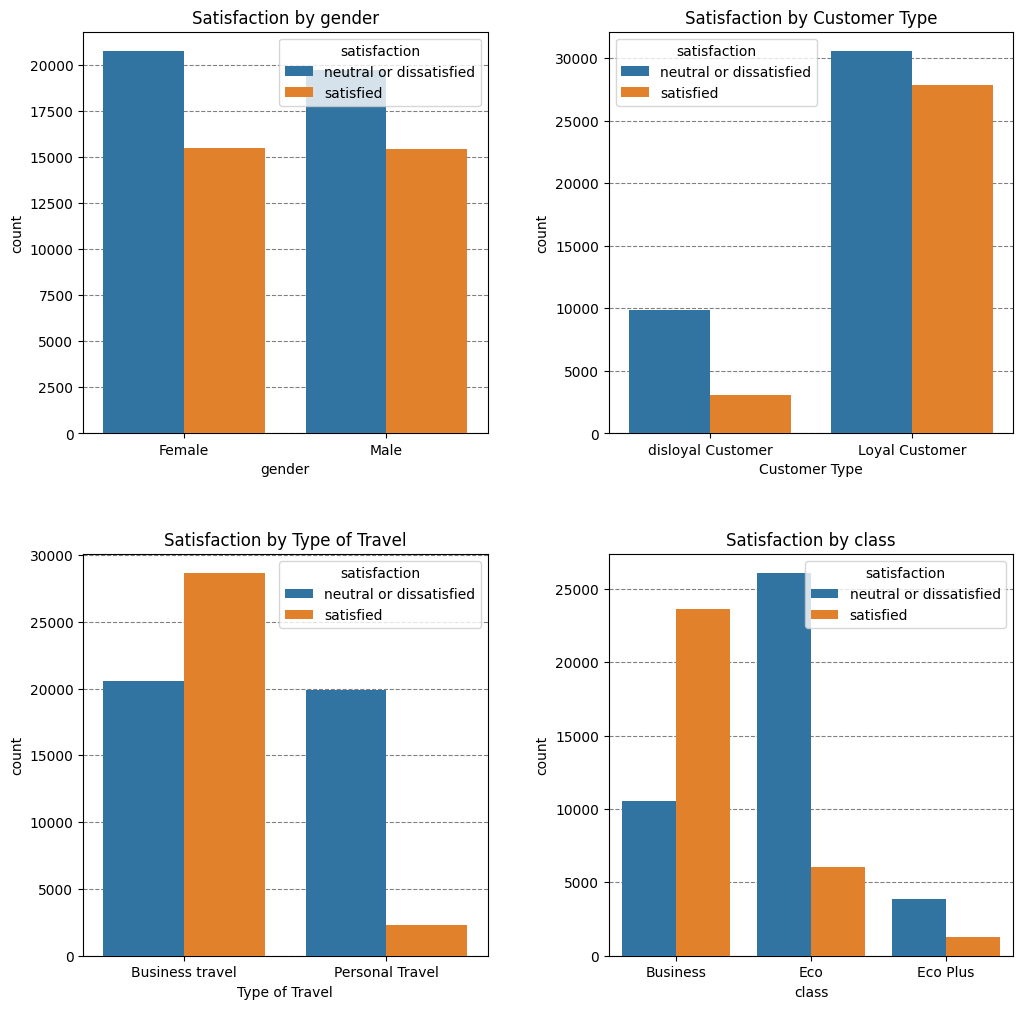

In [171]:
plot_categorical(categorical_cols, X_train, y_train)

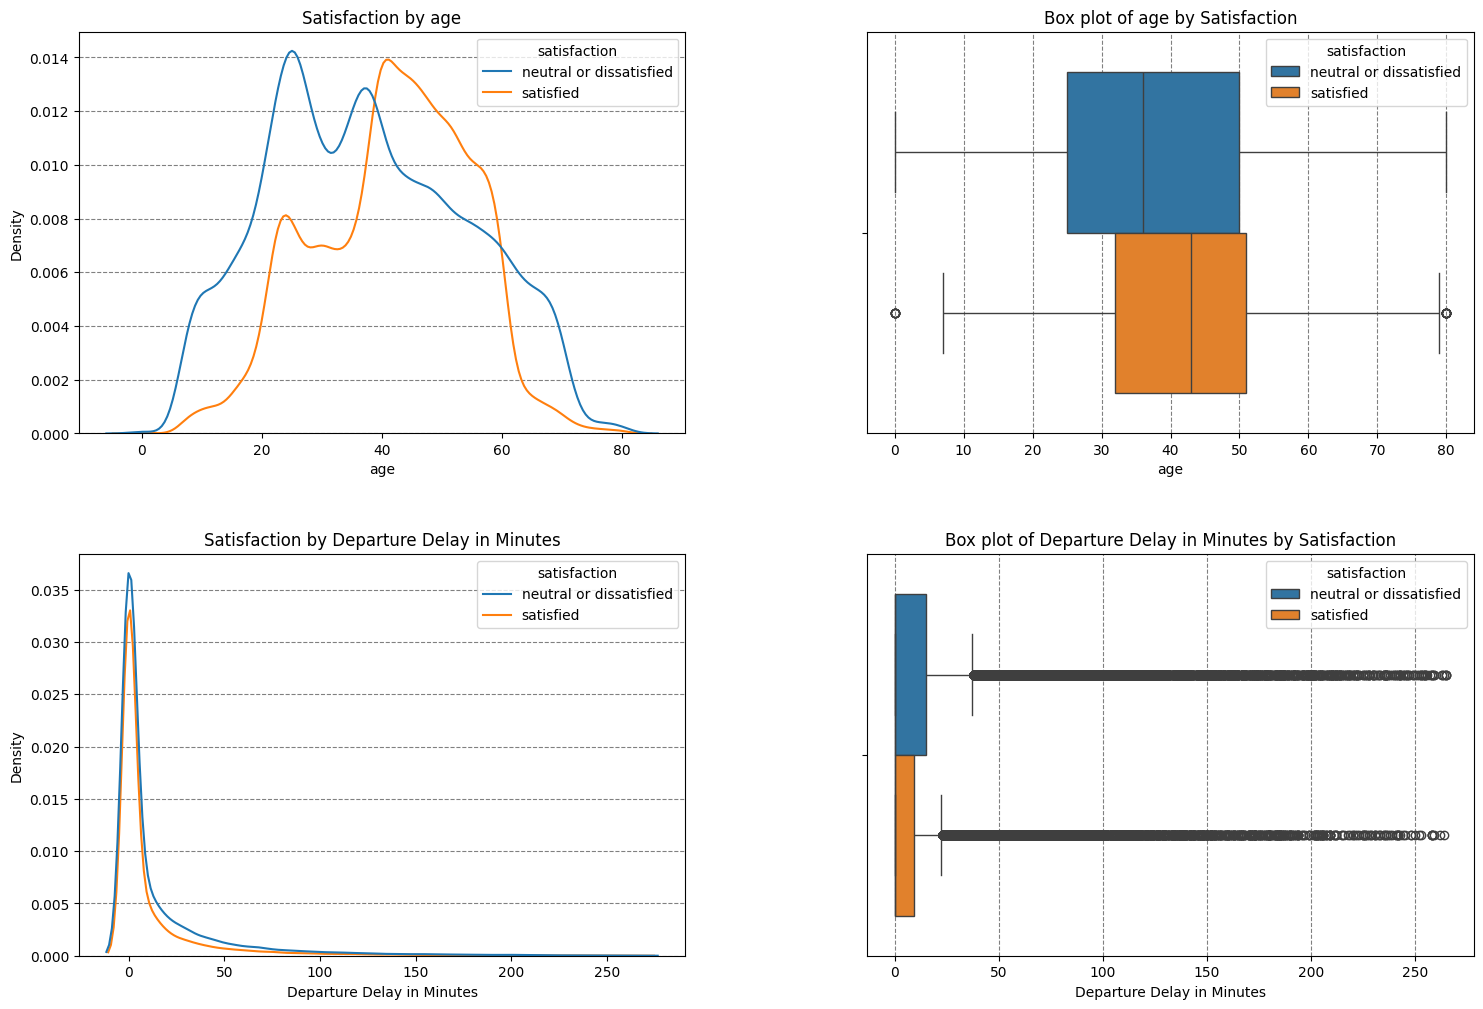

In [175]:
plot_continuous(continuous_cols, X_train, y_train)

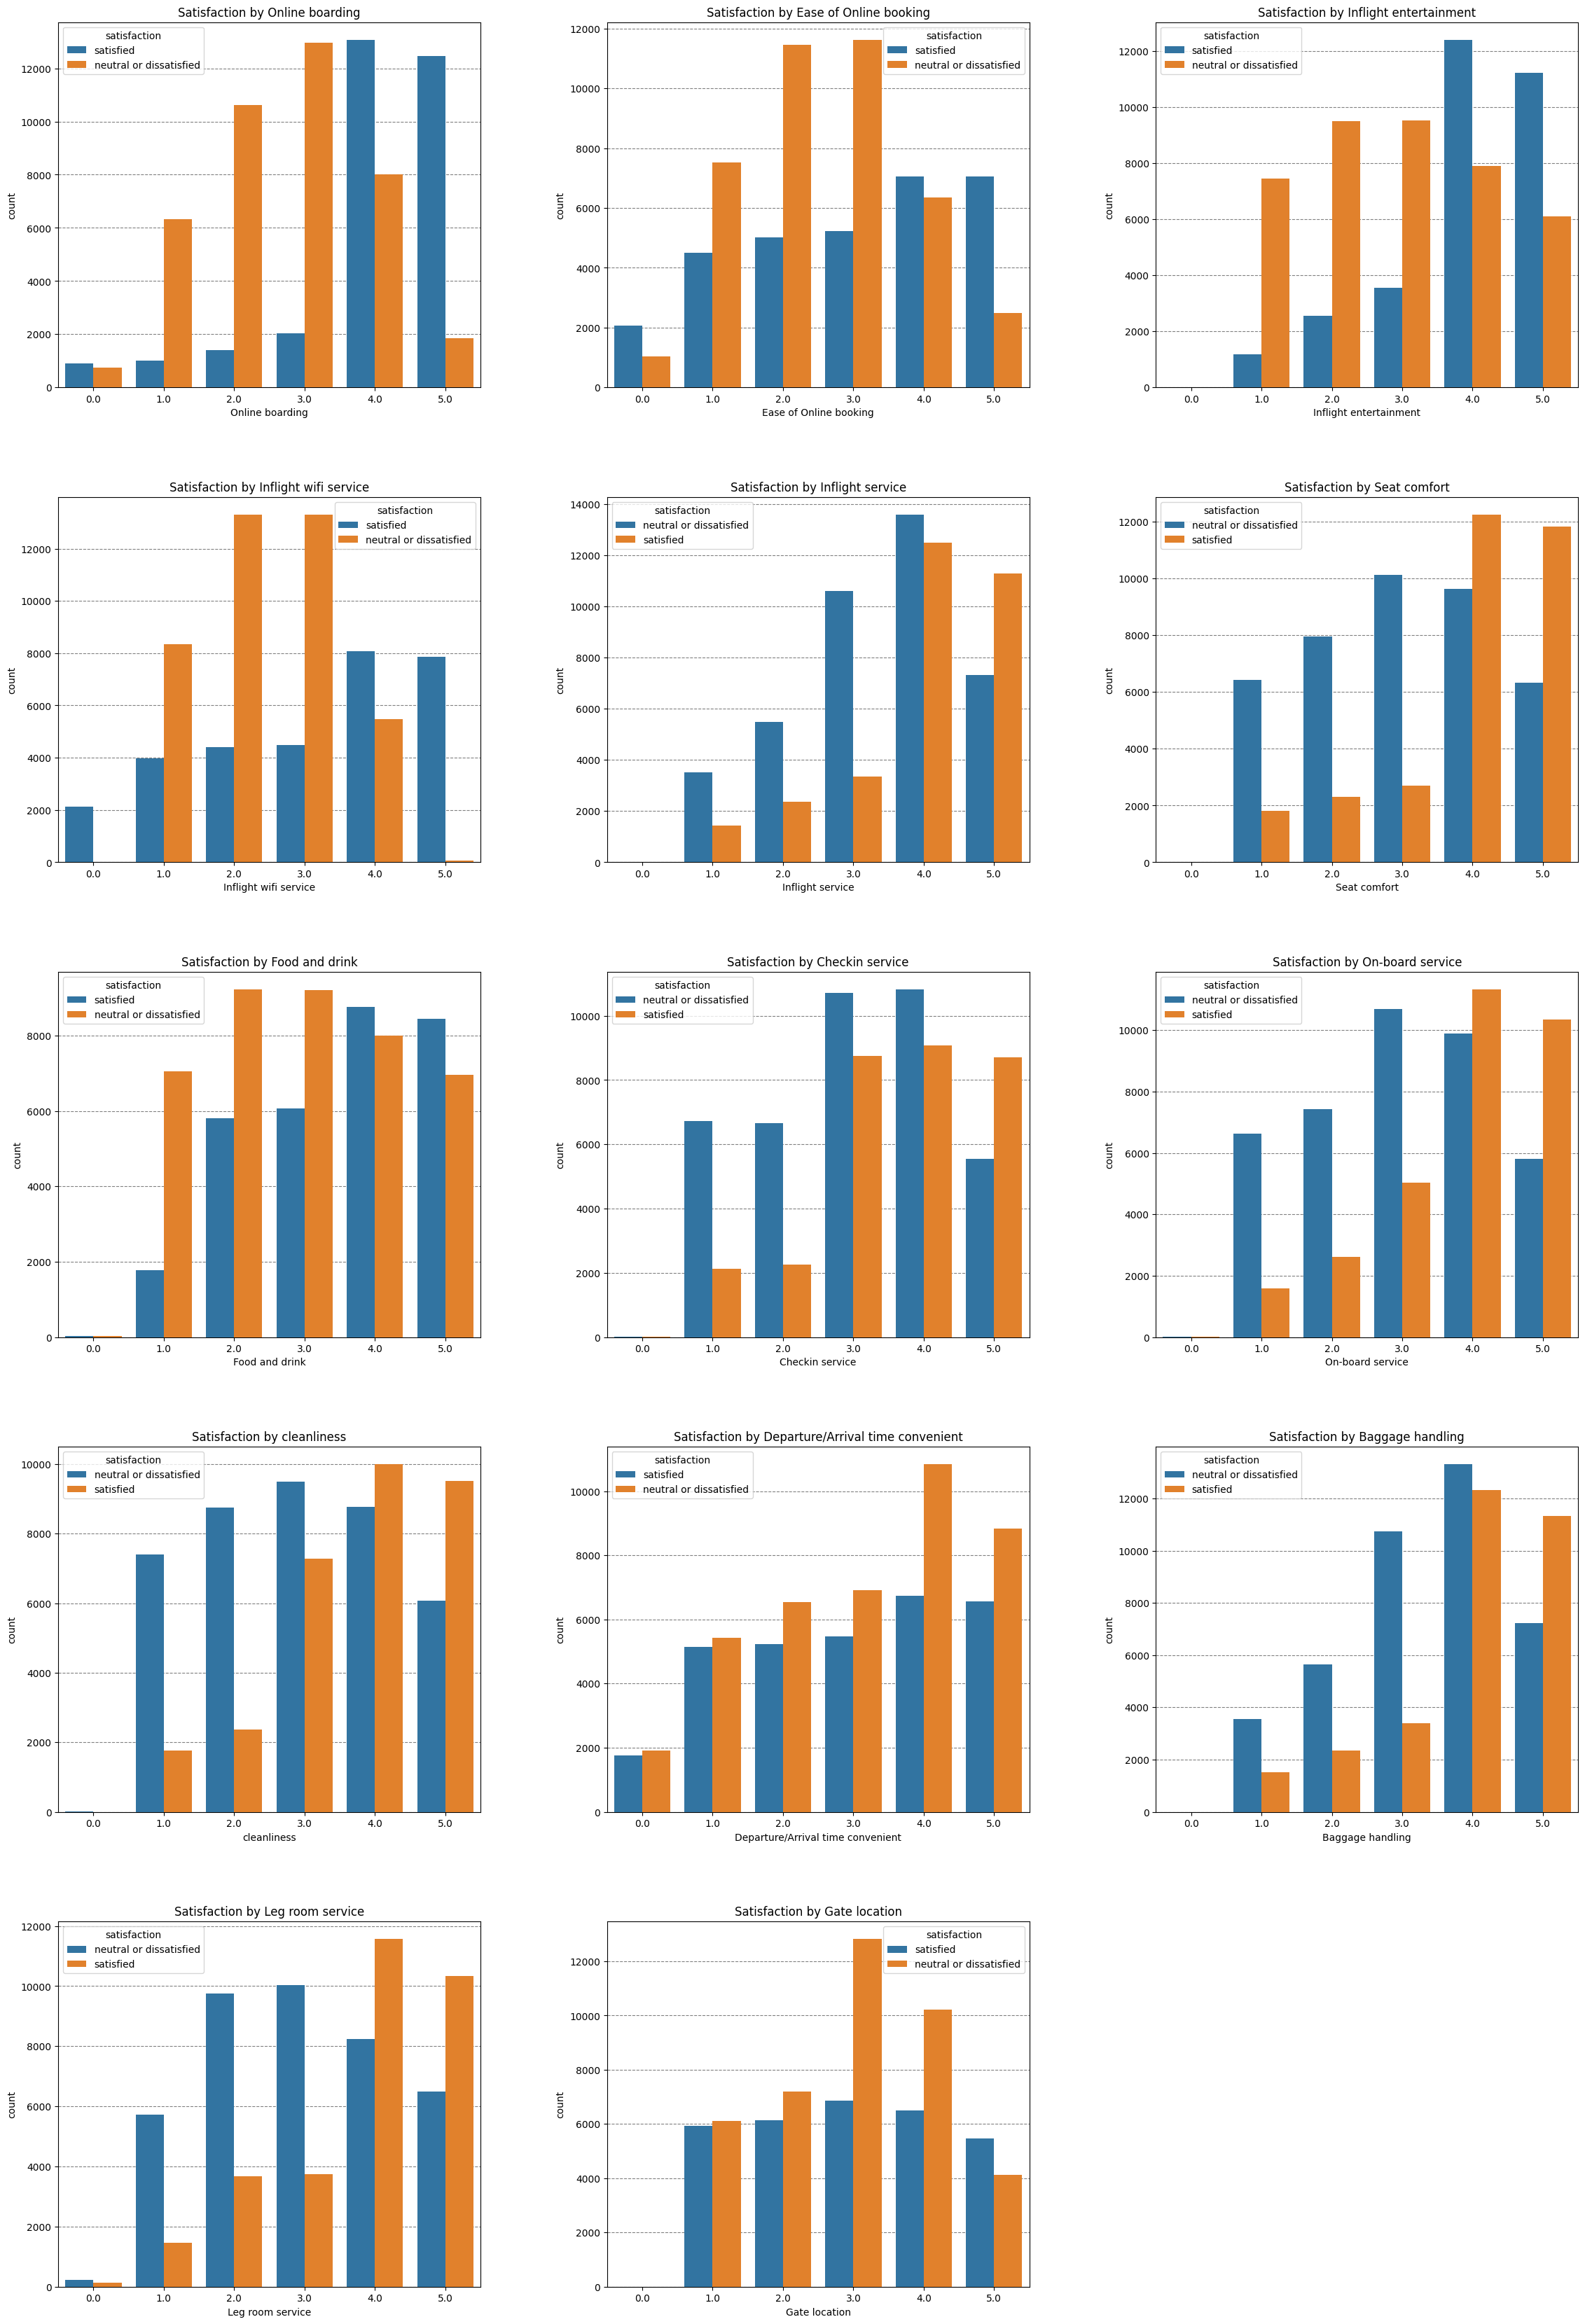

In [173]:
plot_ordinal(ordinal_cols, X_train, y_train)

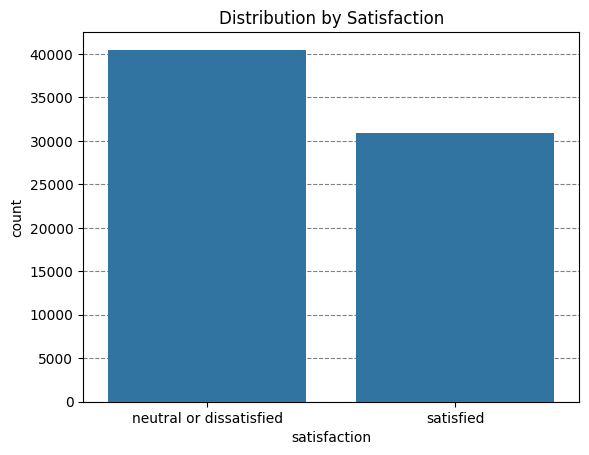

In [167]:
sns.countplot(x=y_train, zorder=3)

plt.title('Distribution by Satisfaction')
plt.grid(axis='y', linestyle='--', color='grey', zorder=1)
plt.show()

### **Задание 8 (0.2 балла)**

Сделайте выводы по построенным графикам.

Не забудьте упомянуть:
* какие признаки распределены неравномерно
* сбалансированы ли классы
* какие распределения имеют континуальные признаки

Выводы:

1. `Удовлетворенность не зависит от пола;`
2. `Customer type и class имеют дисбаланс классов;`
3. `Люди купившие билет на самолет по личным причинам (Personal Travel) редко довольны перелетом;`
4. `Бизнес класс чаще довольны перелетом, а клиенты эконом класса и эконом плюс чаще недовольны;`
5. `Возраст имеет нормальное распределение, а для времени задержки рейса (Departure Delay) сложно определить распределение из-за большого кол-ва выбросов;`
6. `Можно выдвинуть гипотезу о том, что после 40 лет люди чащи довольны перелетом, чем недовольны;`
7. `По порядковым признакам сложно выявить какие-то зависимости;`
8. `Таргет имеет небольшой дисбаланс классов.`

### **Бонус (0.1 балла)**
По графикам (каким, решите сами) оцените, похожи ли оказались распределения признаков при разбиении на трейн, валидацию и тест.

In [41]:
# Ваш код ниже


### **Задание 9 (0.25 балла)**

- Замените признаки "Departure Delay in Minutes" и "Arrival Delay in Minutes" на их логарифмы.
- Заново постройте графики континуальных признаков и сделайте вывод по преобразованию

Некоторые признаки полезно рассматривать в логарифмической шкале. Зачем? Она помогает анализировать большие диапазоны изменений (посмотрите на график логарифма).


In [42]:
# Ваш код ниже

Построение.

In [43]:
plot_continuous(continuous_cols, X_train, y_train)

### **Задание 10 (0.25 балла)**

Выше вы рассмотрели `boxplot` и графики распределений. Но иногда полезным оказывается `scatterplot, (pairplot)` в seabron. Проверьте, что покажет этот график в нашей задаче.

- Отобразите попарное распределение континуальных (по договоренности) признаков. Покрасьте точки на pairplot'е в соответствии с их классом.

**Примечание:**
Наблюдений много, так что отрисовка графика вполне может занять несколько минут

In [44]:
# Ваш код ниже



# **Часть 2. Decision Tree (3 балла)**

### **Задание 11 (0.4 балла)**

Предобработайте данные для алгоритма.
- Закодируйте таргет таким образом, чтоб 'satisfied' перешел в 1, а остальные значения в 0;
- Закодируйте категориальные признаки методом OHE;

In [45]:
# Ваш код ниже

### **Задание 12. (0.1 балла)**

- Обучите дерево решений с параметрами по умолчанию на имеющихся данных.
- Выведите `accuracy_score` для валидационной подвыборки

**Примечание**:

Здесь и далее, где вас просят что-нибудь обучить, выводите **везде** `accuracy_score` для валидационной подвыборки.

In [46]:
# Ваш код ниже

## **Анализ построенной модели**

### **Задание 13. (0.5 балла)**

- Посчитайте bias и variance для построенного дерева. Для этого проще всего вспользоваться функцией `bias_variance_decomp()` из модуля mlxtend. Используйте '0-1_loss'

In [ ]:
# Ваш код ниже — дополните его

error_dt, bias_dt, var_dt = bias_variance_decomp
error_dt, bias_dt, var_dt

### **Задание 14. (0.2 балла)**

Проанализируйте структурные характеристики дерева.
- Какой глубины получилось дерево?
- Сколько в нем листьев?

In [ ]:
# Ваш код ниже

### **Задание 15. (0.3 балла)**

Проанализируйте важность признаков, вычисляемую в дереве по построению.

- Выведите на экран barplot, демонстрирующий оценки важности признаков.
- Укажите, какие признаки оказались наиболее информативными?

In [ ]:
# Ваш код здесь

`Ваш ответ здесь.`  

### **Задание 16. (0.1 балла)**

- Постройте дерево глубины 5, используя только 2 наиболее информативных признака для предыдущего построенного дерева.

In [ ]:
# Ваш код здесь

### **Задание 17. (0.15 балла)**

- С помощью graphviz визуализируйте получившееся новое дерево решений. Почему предикаты в нем не целые, а кратны 1/2?

`Ваш ответ здесь. `

*Гуглить — можно, но помните о культуре цитирования.*

### **Задание 18. (0.25 балла)**

- Теперь отобразите его функцией `plot_tree()` из sklearn.
- Проанализируйте — ссимметричным ли получилось дерево? И хорошо ли это, или нет?

In [ ]:
# Ваш код здесь


### **Задание 19. (0.5 балла)**

- Используя функцию `plot_decision_regions()` из `mlxtend`, отобразите разделяющую поверхность получившегося дерева. Отметьте на графике только первые 100 объектов обучающей выборки

In [ ]:
# Ваш код здесь

### **Деревья решений. Теоретическая вставка**

Из лекций вам должно быть известно, что деревья решений неустойчивы даже к небольшим изменениям в обучающей выборке. Попробуем показать это!

In [ ]:
# замените X_train_example на вашу переменную

fig, ax = plt.subplots(3, 3, figsize=(20, 20))

for row in range(3):
    for col in range(3):
        inds = np.random.choice(X_train_example.index, size=X_train_example.shape[0] - 1000, replace=False) # нагляднее брать не на 1к, а на 5к меньше объектов, а то почти не изменяется разделяющая поверхность

        tree_exp = DecisionTreeClassifier(max_depth=5, random_state=42)
        tree_exp.fit(X_train_example.loc[inds, :], y_train[inds])

        plot_decision_regions(clf=tree_exp, X=np.array(X_train_example.iloc[:100, :]), y=np.array(y_train[:100]), ax=ax[row][col])

**Смотрите как двигается гранится, а ведь мы убирали из трейна (а в нем ~80к наблюдений) всего по тысяче случайных объектов!**

Помимо своей неусточивости деревья решений "славны" ещё и склонностью к переобучению. Посмотрим, можно ли увидеть это свойство на имеющихся у нас данных. Для этого будем обучать алгоритм DT на всем трейне с разной глубиной дерева и считать accuracy для теста

In [ ]:
# замените X_train_example на вашу переменную (ohe-encoded)

%%time
depths = [2, 3, 5, 10, 15, 20, 25, 32, 50, 64, 75, 100]

accuracies_train = []
accuracies_test = []
for max_depth in depths:
    DT = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    DT.fit(X_train_enc, y_train)
    y_predicted_train = DT.predict(X_train_enc)
    y_predicted_val = DT.predict(X_val_enc)
    accuracies_train.append(accuracy_score(y_train, y_predicted_train))
    accuracies_test.append(accuracy_score(y_val, y_predicted_val))

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(depths, accuracies_train, depths, accuracies_test)
plt.legend(['train', 'test'])
plt.ylabel('accuracy')
plt.xlabel('max_depth')
plt.show()

Нам повезло выйти на ассимптоту на тесте. Однако так бывает далеко не всегда. Так что подбирать гипрепараметры для деревьев решений стоит осторожно

## **Возвращение к задаче**

### **Задание 20. (0.4 балла)**

- На кроссвалидации подберите оптимальные гиперпараметры для дерева решений *(по данным со всеми признаками -- не на модельном примере из теоретической вставки)*.
- Удалось ли улучшить качество предсказаний подбором гиперпараметров?

In [ ]:
# you know what to do



### **Задание 21. (0.1 балла)**

- Сохраните лучшее дерево в pickle

*Мы просим это сделать, чтобы вы в случае чего не тратили время на переобучение, а могли банально подгрузить из файла*

In [ ]:
with open('DT.pkl', 'wb') as f:
    pass

# **Часть 3. Random Forest (4.25 балла)**

### **Задание 22. (0.05 балла)**
- Обучите случайный лес с параметрами по умолчанию

In [ ]:
# Ваш код здесь



### **Задание 23. (0.15 балла)**
- Выведите калибровочную кривую для полученного ансамбля

In [ ]:
# Ваш код здесь



Похоже, мы немного недооцениваем высокие вероятности

<img src='https://habrastorage.org/r/w1560/getpro/habr/upload_files/510/4e0/63b/5104e063b62bd0ac6b87da44a3034aa5.png'>

Изображение взято из статьи ["predict_proba в Python не прогнозирует вероятности (и как с этим бороться)"](https://habr.com/ru/company/otus/blog/573924/) с Хабра

### **Задание 24. (0.4 балла)**

- Вспомните (или выведите), корректно ли деревья предсказывают вероятности?



```
Ваш ответ здесь
```



### **Задание 25. (0.15 балла)**
- Обучите логистическую регрессию так, чтобы она сошлась
- Отобразите её калибровочную кривую

In [ ]:
# Ваш код здесь

Мы немного переоцениваем предсказанные низкие вероятности

### **Задание 26. (0.2 балла)**
- Покажите, почему считается, что логистическая регрессия корректно предсказывает вероятности?



```
Ваш ответ здесь
```


### **Задание 27. (0.35 балла)**

Предлагаем вам попробовать откалибровать вероятности обученного случайного леса!

- Откалибруйте вероятности, при помощи логистической и изотонической регрессий.
- Интерпретируйте полученные результаты

In [ ]:
# Ваш код здесь

In [ ]:
# Ваш код здесь (Logreg)

In [ ]:
# Ваш код здесь (isoreg)

### **Задание 28. (0.2 балла)**
- Опишите другие возвожные подходы к калибровке вероятностей (со ссылками на источники)



```
Ваш ответ здесь
```


### **Задание 29. (0.5 баллa)**

Проанализируйте лес.
- Посчитайте разброс и смещение полученного случайного леса (до калибровки).
- Оличаются ли они от полученных для дерева решений?
- Соответствуют ли полученные на реальных данных отличия (//совпадения) от тех, что должны быть в теории? По каким причинам?

In [ ]:
# Ваш код здесь


```
Ваш ответ здесь
```

### **Задание 30. (0.5 баллa)**

- Вычислите разложение ошибки для логистической регрессии (ванильной, которую вы обучили для решения задачи в задании 25, а не той, что использовали для калибровки)
- Сравните полученные результаты с предыдущими.
- Объясните природу этих результатов

In [ ]:
# Ваш код здесь


### **Задание 31. (0.8 баллa)**

- Попробуйте подобрать оптимальные гиперпараметры леса, используя [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html).

**Важно:**  

Хотя бы один из гиперпараметров перебирайте из распределения (например, `uniform` из `scipy.stats`)

In [ ]:
# Ваш код здесь


## **Случайный лес. Вставка теории**

На модельном примере посмотрим, склонен ли случайный лес к переобучению с ростом числа деревьев в композиции.

Возьмем 4 полезных признака из одного из предыдщущих заданий, напоминающих теорию

In [ ]:
# замените X_train_enc на ваш трейн

cols_for_RF = ['age', 'Flight Distance', 'Online boarding', 'Inflight wifi service']
X_train_RF = X_train_enc[cols_for_RF]
# а тест нам не понадобится, ведь можно получить OOB-estimate ошибки

clf = RandomForestClassifier(warm_start=True, oob_score=True, random_state=42)
errors = []

for n_estimators in range(1, 251, 5):
    clf.set_params(n_estimators=n_estimators)
    clf.fit(X_train_RF, y_train)

    errors.append(1 - clf.oob_score_)

In [ ]:
plt.figure(figsize=(20, 14))
plt.plot(range(1, 251, 5), errors)

plt.xlabel('n_estimators')
plt.ylabel('OOB score')
plt.show()

**Дисклеймер**: отсутствие переобучения с ростом числа деревьев вовсе не означает, что сама модель случайного леса не может быть переобучена. Базовые деревья такой композиции могут переобучаться. Значит, и вся композиция вполне способна оказаться переобученной

## **Возвращение к задаче**

### **Задание 32. (0.6 баллa)**

- Отобразите`feature_importances_` вашего лучшего случайного леса
- Сравните важности признаков для дерева решений и для случайного леса. Постройте диаграмму


In [ ]:
# Ваш код здесь

In [ ]:
# Ваш код здесь

### **Задание 33. (0.1 баллa)**

- Случайный лес, дающий лучший скор, [сохраните в pickle](https://scikit-learn.ru/stable/model_persistence.html)

### **Задание 34. (0.25 балла)**
- Интерпретируйте важности признаков с помощью SHAP.
- Опишите полученый график

**Важно:** Для подсчета используйте 1000 случайных объектов, иначе не дождетесь за приемлемое время

**Вам может помочь:** [Статья "Интерпретация моделей и диагностика сдвига данных: LIME, SHAP и Shapley Flow"](https://habr.com/ru/company/ods/blog/599573/) из блога ods.ai на Хабре

In [ ]:
# Ваш код здесь


`Ваш ответ здесь`

### **Бонус (0.1 балл)**

- Изучите документацию библиотеки SHAP. Что ещё полезного в ней имеется?

`Ваш ответ здесь`

### **Бонус (0.5 балла)**

- Интерпретируйте важности признаков для одного прогноза с помощью LIME;
- Опишите полученный график для выбранного наблюдения

In [ ]:
# Ваш код здесь


`Ваш ответ здесь`

## Котобонус!

0.25 балла

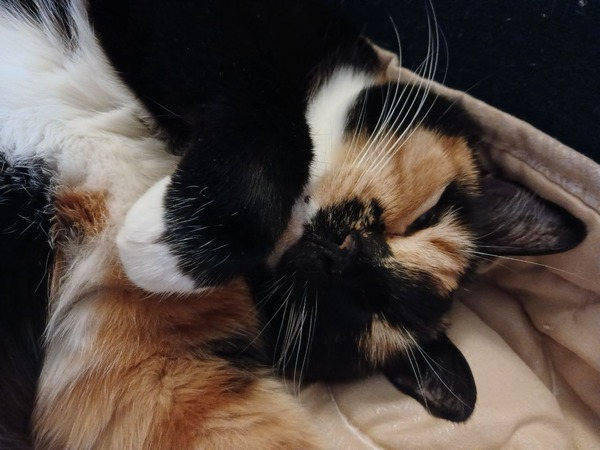

# Обратная связь

Расскажите, как вам это домашнее задание. Было ли оно полезным? Научились ли вы чему то? Насколько сложным по 10-балльной шкале оно вам показалось? Сколько времени у вас ушло на его выполнение? Что следовало ещё в него включить? Было ли что-то лишнее?